$\textbf{Student:}$ Carlos Daniel Fontes da Silva\
$\textbf{E-mail:}$ carlos.fontes@ee.ufcg.edu.br

# Coaxial cable

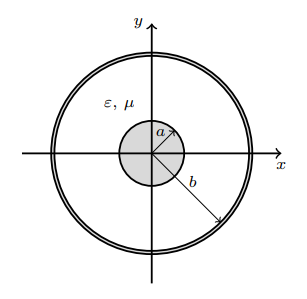

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.special import jv, jvp, yv, yvp, jn_zeros, jnp_zeros
from scipy.constants import c, pi, mu_0, epsilon_0
from scipy.signal import find_peaks
from numpy.lib.scimath import sqrt as csqrt

In [17]:
f = 1e9*np.linspace(1, 60, 1000)   # Frequency range
k = 2*np.pi*f/c                    # Wave number
F = 50e9                           # Operation frequency

# Guide geometry
a = 0.1e-2                         # intern radius
b = 2.0e-2                         # extern radius

# Dielectric settings
σd = 0                             # Conductivity
ε = 1 * epsilon_0                  # Permittivity
μ = 1 * mu_0                       # Permeability
η = np.sqrt(μ/ε)                   # Intrinsic impedance

## 1 - TEM mode

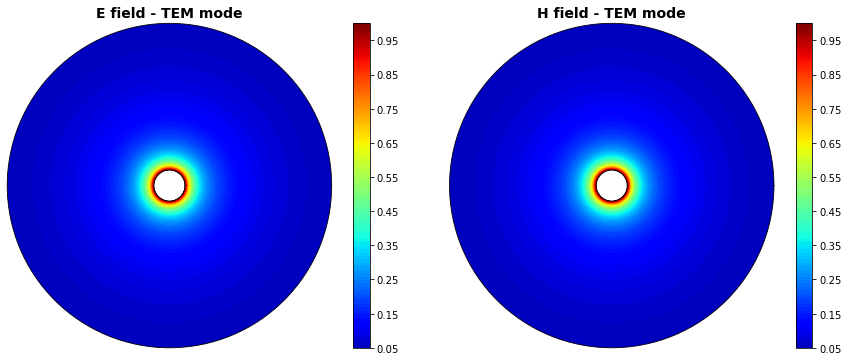

In [18]:
fig, axs = plt.subplots(1, 2, figsize = (12.5, 5),subplot_kw=dict(projection='polar'))
mycmap = plt.get_cmap('jet')

ρ = np.linspace(a, b, 50)
Φ = np.linspace(0, 2*np.pi, 50)
z = 0.1
ρ, Φ = np.meshgrid(ρ, Φ)

K = 2*pi*F/c
β = K

Eρ = np.abs((1/(np.log(b/a)*ρ))*np.exp(1j*β*z))
HΦ = np.abs((1/(np.log(b/a)*ρ))*np.exp(1j*β*z))

Emax = np.max(Eρ)

field = axs[0].contourf(Φ, ρ*1e2, Eρ/Emax, 100, cmap = mycmap, vmin = 0, vmax = 1)
fig.colorbar(field, ax = axs[0])
axs[0].set_title('E field - TEM mode', fontsize = 14, fontweight = 'bold')
axs[0].set_rorigin(-1e2*a)
axs[0].set_rlim(1e2*a,1e2*b)
axs[0].grid(False)
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])

field = axs[1].contourf(Φ, ρ*1e2, HΦ/Emax, 100, cmap = mycmap, vmin = 0, vmax = 1)
fig.colorbar(field, ax = axs[1])
axs[1].set_title('H field - TEM mode', fontsize = 14, fontweight = 'bold')
axs[1].set_rorigin(-1e2*a)
axs[1].set_rlim(1e2*a, 1e2*b)
axs[1].grid(False)
axs[1].set_xticklabels([])
axs[1].set_yticklabels([])

plt.tight_layout()

## 2 - TE modes

### 2.1 - Propagated modes

In [19]:
def propagation_TE(F, f):
    modes = list(itertools.product([1,2,3], [1,2,3,4,5]))
    
    M = modes[-1][0]
    N = modes[-1][1]

    p = 0
    kc = 2*pi*f/c
    
    fc = np.zeros(N)
    prop = np.zeros((len(modes), 3))
    
    for i in range(M):
        m = modes[N*i][0]
        
        LHS = jvp(m, kc*a)/jvp(m, kc*b)
        RHS = yvp(m, kc*a)/yvp(m, kc*b)
        
        LHS[LHS > 30]  = 'NaN'
        LHS[LHS < -30] = 'NaN'
        RHS[RHS > 30]  = 'NaN'
        RHS[RHS < -30] = 'NaN'

        peak, _   = find_peaks( - abs(LHS - RHS), height = -2)
        fc = f[peak][0:N]
        
        for j in range(len(fc)):
            if(F > fc[j]):
                prop[p,:] = np.array([m, j+1, fc[j]])
                p += 1
                
    prop = prop[~np.all(prop == 0, axis=1)]
    prop = prop[prop[:, 2].argsort()]

    return prop

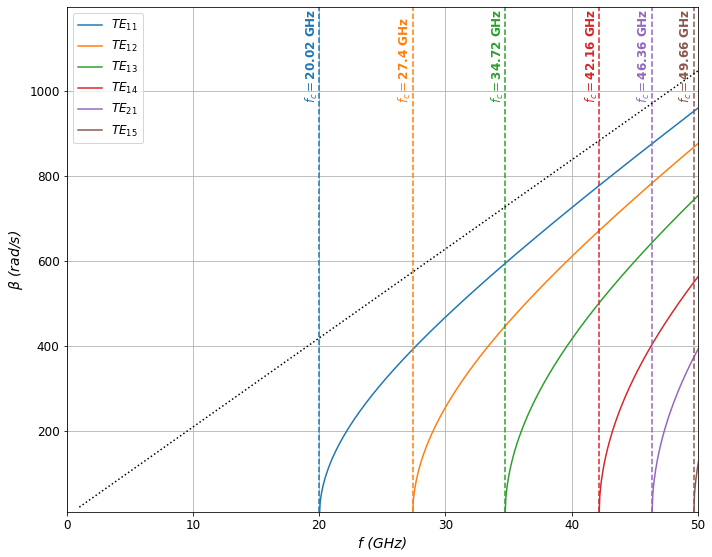

In [20]:
plt.figure(figsize = (10,8))

prop = propagation_TE(F, f)

for i in range(len(prop)):
    m, n = prop[i,0:2]
    fc = prop[i,2]
    
    kc = 2*pi*fc/c
    β = np.real(csqrt(k**2 - kc**2))
    
    p = plt.plot(f*1e-9, β, label = r'$TE_{'+str(int(m))+str(int(n))+'}$')
    plt.text(1e-9*fc-0.6, k[np.where(f > F)[0][0]] - 65, r'$f_c = $'+str(round(1e-9*fc,2))+' GHz',fontsize = 12, color = p[-1].get_color(),fontweight = 'bold',ha = 'center', rotation = 90) 
    plt.axvline(1e-9*fc, ls = '--', color = p[-1].get_color())
        
plt.plot(1e-9*f, k, ls = ':', color = 'k')
plt.ylabel(r'$\beta$ (rad/s)', fontsize = 14, fontstyle = 'italic')
plt.xlabel('f (GHz)', fontsize = 14, fontstyle = 'italic')
plt.xlim(0, F*1e-9)
plt.ylim(10, k[np.where(f > F)[0][0]] + 150)
plt.tick_params(axis = 'both', labelsize = 12)
plt.legend(fontsize = 12)
plt.grid()
plt.tight_layout()

### 2.2 - Field profiles

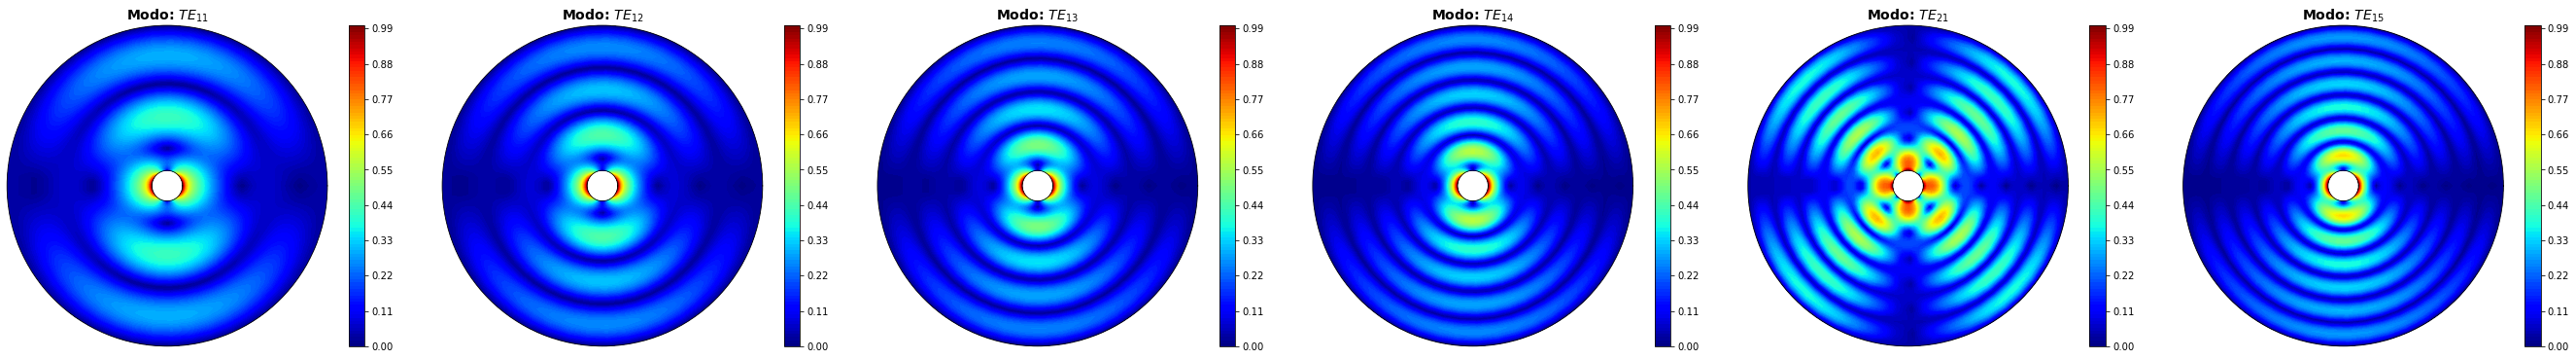

In [6]:
fig, axs = plt.subplots(1, len(prop), figsize = (6.25*len(prop), 5),subplot_kw=dict(projection='polar'), squeeze=False)
mycmap = plt.get_cmap('jet')

ρ = np.linspace(a, b, 50)
Φ = np.radians(np.linspace(0, 360, 50))
z = 0.1
ρ, Φ = np.meshgrid(ρ, Φ)

for i in range(len(prop)):
    m, n = prop[i,0:2]
    fc = prop[i,2]

    Kc = 2*pi*fc/c
    K = 2*pi*F/c
    β = csqrt(K**2 - Kc**2)
    
    Eρ = (-1j*2*np.pi*F*μ*m/(Kc**2*ρ))*np.cos(m*Φ)*(jv(m, Kc*ρ) - yv(m, Kc*ρ)*jvp(m, Kc*a)/yvp(m, Kc*a) )*np.exp(1j*β*z)
    EΦ = (1j*2*np.pi*F*μ/(Kc))*np.sin(m*Φ)*(jvp(m, Kc*ρ) - yvp(m, Kc*ρ)*jvp(m, Kc*a)/yvp(m, Kc*a))*np.exp(1j*β*z)
    Ez = 0

    E = np.sqrt(abs(Eρ)**2 + abs(EΦ)**2 + abs(Ez)**2)
    Emax = np.max(E)
    
    field = axs[0,i].contourf(Φ, ρ*1e2, E/Emax, 100, cmap = mycmap, vmin = 0, vmax = 1)
    fig.colorbar(field, ax = axs[0,i])
    axs[0,i].set_title('Modo: $TE_{'+str(int(m))+str(int(n))+'}$', fontsize = 14, fontweight = 'bold')
    axs[0,i].set_rorigin(-1e2*a)
    axs[0,i].grid(False)
    axs[0,i].set_xticklabels([])
    axs[0,i].set_yticklabels([])
    
plt.tight_layout()

## 3 - TM modes

### 3.1 - Propagated modes

In [7]:
def propagation_TM(F, f):
    modes = list(itertools.product([1,2,3], [1,2,3,4,5]))
    
    M = modes[-1][0]
    N = modes[-1][1]

    p = 0
    kc = 2*pi*f/c
    
    fc = np.zeros(N)
    prop = np.zeros((len(modes), 3))
    
    for i in range(M):
        m = modes[N*i][0]
        
        LHS = jv(m, kc*a)/jv(m, kc*b)
        RHS = yv(m, kc*a)/yv(m, kc*b)
        
        LHS[LHS > 30]  = 'NaN'
        LHS[LHS < -30] = 'NaN'
        RHS[RHS > 30]  = 'NaN'
        RHS[RHS < -30] = 'NaN'

        peak, _   = find_peaks( - abs(LHS - RHS), height = -2)
        fc = f[peak][0:N]
        
        for j in range(len(fc)):
            if(F > fc[j]):
                prop[p,:] = np.array([m, j+1, fc[j]])
                p += 1
                
    prop = prop[~np.all(prop == 0, axis=1)]
    prop = prop[prop[:, 2].argsort()]

    return prop

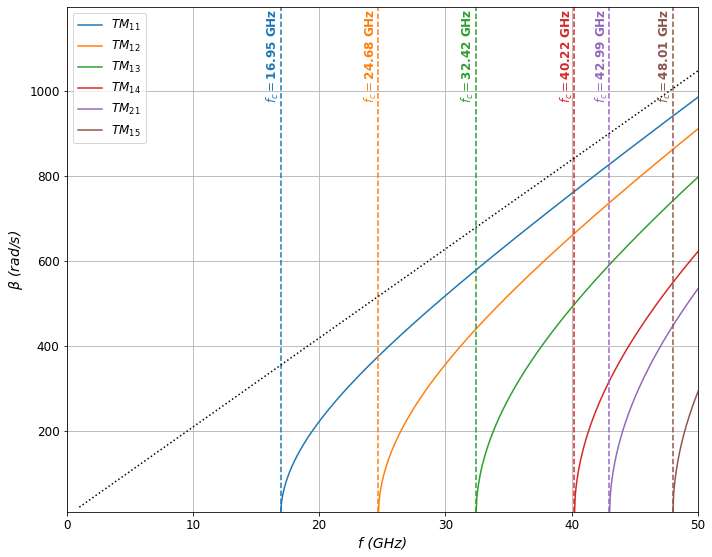

In [14]:
plt.figure(figsize = (10,8))

prop = propagation_TM(F, f)

for i in range(len(prop)):
    m, n = prop[i,0:2]
    fc = prop[i,2]
    
    kc = 2*pi*fc/c
    β = np.real(csqrt(k**2 - kc**2))
    
    p = plt.plot(f*1e-9, β, label = r'$TM_{'+str(int(m))+str(int(n))+'}$')
    plt.text(1e-9*fc-0.6, k[np.where(f > F)[0][0]] - 65, r'$f_c = $'+str(round(1e-9*fc,2))+' GHz',fontsize = 12, color = p[-1].get_color(),fontweight = 'bold',ha = 'center', rotation = 90) 
    plt.axvline(1e-9*fc, ls = '--', color = p[-1].get_color())
        
plt.plot(1e-9*f, k, ls = ':', color = 'k')
plt.ylabel(r'$\beta$ (rad/s)', fontsize = 14, fontstyle = 'italic')
plt.xlabel('f (GHz)', fontsize = 14, fontstyle = 'italic')
plt.xlim(0, F*1e-9)
plt.ylim(10, k[np.where(f > F)[0][0]] + 150)
plt.tick_params(axis = 'both', labelsize = 12)
plt.legend(fontsize = 12)
plt.grid()
plt.tight_layout()

### 3.2 - Field profiles

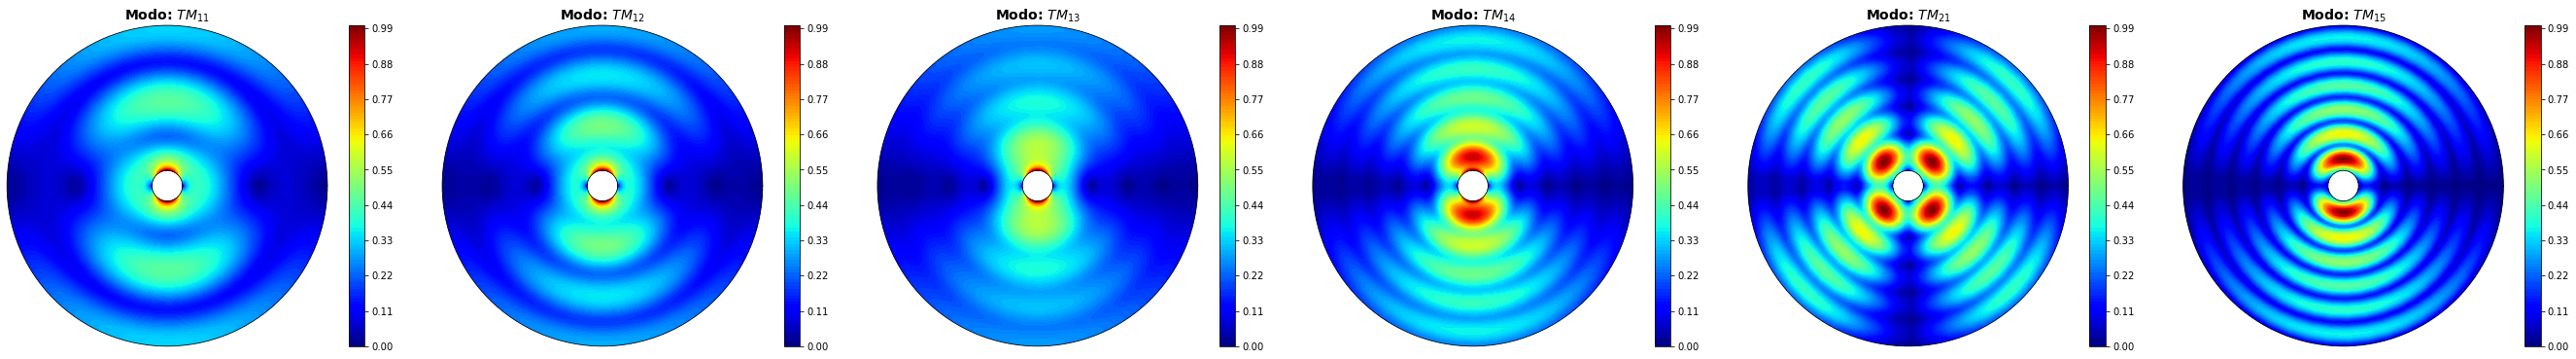

In [9]:
fig, axs = plt.subplots(1, len(prop), figsize = (6.25*len(prop), 5),subplot_kw=dict(projection='polar'), squeeze=False)
mycmap = plt.get_cmap('jet')

ρ = np.linspace(a, b, 50)
Φ = np.radians(np.linspace(0, 360, 50))
z = 0.1
ρ, Φ = np.meshgrid(ρ, Φ)

for i in range(len(prop)):
    m, n = prop[i,0:2]
    fc = prop[i,2]

    Kc = 2*pi*fc/c
    K = 2*pi*F/c
    β = csqrt(K**2 - Kc**2)
    
    Eρ = (-1j*β/(Kc))*np.sin(m*Φ)*(jvp(m, Kc*ρ) - yvp(m, Kc*ρ)*jv(m, Kc*a)/yv(m, Kc*a) )*np.exp(1j*β*z)
    EΦ = (-1j*β*m/(ρ*Kc**2))*np.cos(m*Φ)*(jv(m, Kc*ρ) - yv(m, Kc*ρ)*jv(m, Kc*a)/yv(m, Kc*a))*np.exp(1j*β*z)
    Ez = np.sin(m*Φ)*(jv(m, Kc*ρ) - yv(m, Kc*ρ)*jv(m, Kc*a)/yv(m, Kc*a) )*np.exp(1j*β*z)

    E = np.sqrt(abs(Eρ)**2 + abs(EΦ)**2 + abs(Ez)**2)
    Emax = np.max(E)
    
    field = axs[0,i].contourf(Φ, ρ*1e2, E/Emax, 100, cmap = mycmap, vmin = 0, vmax = 1)
    fig.colorbar(field, ax = axs[0,i])
    axs[0,i].set_title('Modo: $TM_{'+str(int(m))+str(int(n))+'}$', fontsize = 14, fontweight = 'bold')
    axs[0,i].set_rorigin(-1e2*a)
    axs[0,i].grid(False)
    axs[0,i].set_xticklabels([])
    axs[0,i].set_yticklabels([])
    
plt.tight_layout()